<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #3
## Деревья решений на игрушечной задаче и на наборе данных UCI Adult

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

### Часть 1. Игрушечный набор данных "Will They? Won't They?"

Ваша цель - понять, как работают деревья решений, рассмотрев игрушечную задачу. Хотя одно дерево решений не дает выдающихся результатов, другие эффективные алгоритмы, такие как gradient boosting и random forests, основаны на той же идее. Поэтому знание того, как работают деревья решений, может оказаться полезным.

Рассмотрим игрушечный пример бинарной классификации - человек А решает, пойдет ли он на второе свидание с человеком Б. Это будет зависеть от его внешности, красноречия, употребления алкоголя (только для примера), а также от того, сколько денег было потрачено на первом свидании.

#### Создание набора данных

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

#### Training data

In [4]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Test data

In [5]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Looks_handsome,Money_spent_little,Eloquence_high,Eloquence_average,Looks_repulsive,Alcoholic_beverage_yes,Alcoholic_beverage_no,Money_spent_lots
0,1,0,1,0,0,1,0,1
1,1,1,0,0,0,1,0,0
2,1,0,0,1,0,0,1,1
3,0,1,0,1,1,0,1,0
4,0,0,0,0,1,1,0,1
5,0,0,1,0,1,1,0,1
6,1,0,0,1,0,1,0,1


In [7]:
df_test

,Looks_handsome,Money_spent_little,Eloquence_high,Eloquence_average,Looks_repulsive,Alcoholic_beverage_yes,Alcoholic_beverage_no,Money_spent_lots
0,1,0,0,1,0,0,1,1
1,1,1,1,0,0,1,0,0
2,0,0,0,1,1,1,0,1


**1. Какова энтропия $S_0$ исходной системы? Под состояниями системы понимаются значения бинарного признака "Will_go" - 0 или 1 - всего два состояния**.

In [8]:
from math import log2
from IPython.display import display, Math, Latex


def calc_entropy(_y, _idx: int = 0) -> tuple[float, str]:
    entropy = 0.
    result = f"$$ S_{_idx} ="
    
    size = _y.size
    for i in [0, 1]:
        occ = (_y == i).sum()
        p = occ / size
        entropy -= p * log2(p)
        frac = f"\\frac{{{occ}}}{{{size}}}"
        result += f" - {frac}\\log_2{{{frac}}}"
    
    result += f" = {entropy:.3f} $$"
    
    return (entropy, result)

In [9]:
S_0, latex_S_0 = calc_entropy(y)
display(Math(latex_S_0))

<IPython.core.display.Math object>

$$ S_0 = - \frac{4}{7}\log_2{\frac{4}{7}} - \frac{3}{7}\log_2{\frac{3}{7}} = 0.985 $$

**2. Разделим данные по признаку "Looks_handsome". Какова энтропия $S_1$ левой группы - той, в которой есть "Looks_handsome". Какова энтропия $S_2$ в противоположной группе? Каков информационный прирост (IG), если рассматривать такое разбиение?**

In [10]:
def calc_information_gain(_y, _partitions) -> tuple[float, str]:
    information_gain = calc_entropy(_y)[0]
    result = f"$$ IG = S_0"
    
    size = _y.size
    for i, partition in enumerate(_partitions):
        entropy = calc_entropy(partition)[0]
        information_gain -= (len(partition) / size) * calc_entropy(partition)[0]
        result += f" - \\frac{{{len(partition)}}}{{{size}}}S_{i + 1}"
    result += f" = {information_gain:.3f} $$"
    
    return (information_gain, result)

In [11]:
S_1, latex_S_1 = calc_entropy(y[df_train["Looks_handsome"] == 1], 1)
S_2, latex_S_2 = calc_entropy(y[df_train["Looks_handsome"] == 0], 2)
IG, latex_IG = calc_information_gain(y, [
    y[df_train["Looks_handsome"] == 1],
    y[df_train["Looks_handsome"] == 0]]
)

display(Math(latex_S_1))
display(Math(latex_S_2))
display(Math(latex_IG))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$$ S_1 =  - \frac{3}{4}\log_2{\frac{3}{4}} - \frac{1}{4}\log_2{\frac{1}{4}} = 0.811 $$
$$ S_2 =  - \frac{1}{3}\log_2{\frac{1}{3}} - \frac{2}{3}\log_2{\frac{2}{3}} = 0.918 $$
$$ IG = S_0 - \frac{4}{7}S_1 - \frac{3}{7}S_2 = 0.128 $$

#### Обучите дерево решений с помощью sklearn на обучающих данных. Вы можете выбрать любую глубину дерева.

In [12]:
dt = DecisionTreeClassifier(criterion="entropy", random_state=0)

In [13]:
dt.fit(df_train, y);

#### Дополнительно: отобразить полученное дерево с помощью graphviz. Можно использовать pydot или [web-service](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

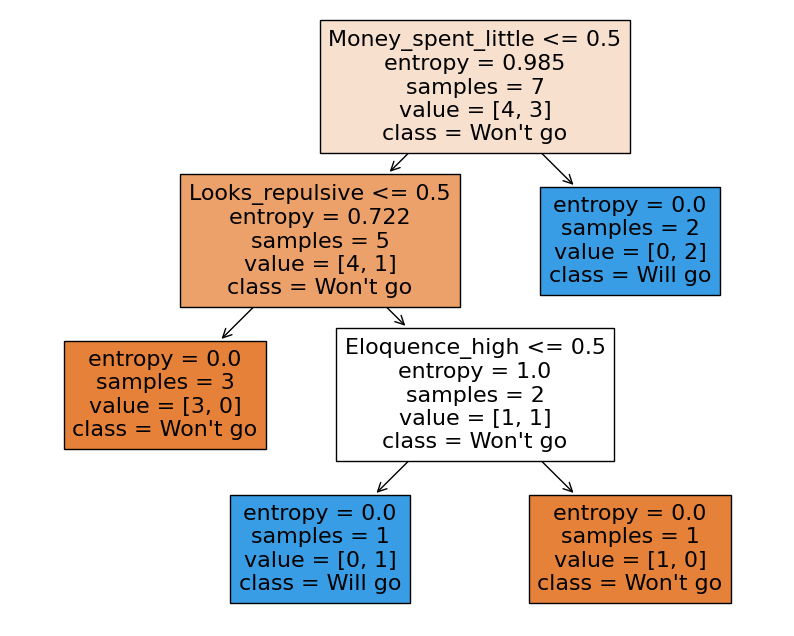

In [14]:
plot_tree(
    dt, feature_names=df_train.columns, filled=True, class_names=["Won't go", "Will go"]
);

### Часть 2. Функции для вычисления энтропии и прироста информации.

Рассмотрим следующий пример для разминки: у нас есть 9 синих шаров и 11 желтых шаров. Пусть шар имеет метку **1**, если он синий, и **0** в противном случае.

In [15]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src = '../img/decision_tree3.png'>

Затем разделим шары на две группы:

<img src = '../img/decision_tree4.png'>

In [16]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

#### Реализовать функцию для вычисления энтропии Шеннона.

In [17]:
def entropy(a_list):
    lst = list(a_list)
    entropy = 0.
    size = len(lst)
    nunique = len(set(lst))
    if nunique == 0 or nunique == 1:
        return entropy
    for i in set(lst):
        occ = lst.count(i)
        p = occ / size
        entropy -= p * log2(p)
    return entropy

Тесты

In [18]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


**3. Какова энтропия состояния, заданного списком *balls_left*?**

In [19]:
display(Math(f"$$ {entropy(balls_left):.3f} $$"))

<IPython.core.display.Math object>

**4. Какова энтропия игральной кости? (когда мы рассматриваем игральную кость как систему с 6 равновероятными состояниями)?**

In [20]:
display(Math(f"$$ {entropy([1, 2, 3, 4, 5, 6]):.3f} $$"))

<IPython.core.display.Math object>

In [21]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""
    return (
        entropy(root)
        - (len(left) / len(root)) * entropy(left)
        - (len(right) / len(root)) * entropy(right)
    )

**5. Каков информационный прирост от разбиения исходного набора данных на *balls_left* и *balls_right*?**

In [22]:
display(Math(f"$$ {information_gain(balls, balls_left, balls_right):.3f} $$"))

<IPython.core.display.Math object>

In [23]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return out

#### Дополнительно:
- Реализовать алгоритм построения дерева решений путем рекурсивного вызова `information_gains`.
- Построить результирующее дерево

In [24]:
information_gains(df_train, y)

[0.12808527889139443,
 0.46956521111470695,
 0.2916919971380597,
 0.020244207153756077,
 0.12808527889139443,
 0.0059777114237740125,
 0.0059777114237740125,
 0.46956521111470695]

In [25]:
def tree(X, y, f_names):
    igs = information_gains(X, y)
    best_feature = f_names[igs.index(max(igs))]
    
    X_left = X[X[best_feature] == 0]
    X_right = X[X[best_feature] == 1]
    
    y_left = y[X[best_feature] == 0]
    y_right = y[X[best_feature] == 1]
    
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    
    # TODO: add graphviz vizualization of tree
    print(
        f"Best feature: {best_feature}\n"
        + f"Samples:\n"
        + f"    left: {len(X_left)} right: {len(X_right)}\n"
        + f"Entropy:\n"
        + f"    left: {entropy_left:.3f} right: {entropy_right:.3f}\n"
        + f"__________________________________________________\n"
    )
    if entropy_left != 0.:
        print(f"Split left with {len(X_left)} samples:")
        tree(X_left, y_left, f_names)
    if entropy_right != 0.:
        print(f"Split right with {len(X_right)} samples:")
        tree(X_right, y_right, f_names)

In [26]:
tree(df_train, y, df_train.columns)

Best feature: Money_spent_little
Samples:
    left: 5 right: 2
Entropy:
    left: 0.722 right: 0.000
__________________________________________________

Split left with 5 samples:
Best feature: Looks_handsome
Samples:
    left: 2 right: 3
Entropy:
    left: 1.000 right: 0.000
__________________________________________________

Split left with 2 samples:
Best feature: Eloquence_high
Samples:
    left: 1 right: 1
Entropy:
    left: 0.000 right: 0.000
__________________________________________________



### Часть 3. Набор данных "Adult"

#### Описание набора данных:
[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult: классификация людей по демографическим данным - зарабатывают ли они более \$50 000 в год или нет.

Описание признаков:
- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Martial_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

#### Чтение обучающих и тестовых данных

In [27]:
data_train = pd.read_csv("../data/adult_train.csv", sep=";")

In [28]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [29]:
data_test = pd.read_csv("../data/adult_test.csv", sep=";")

In [30]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [31]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

#### Анализ первичных данных

In [32]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_train["Target"].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

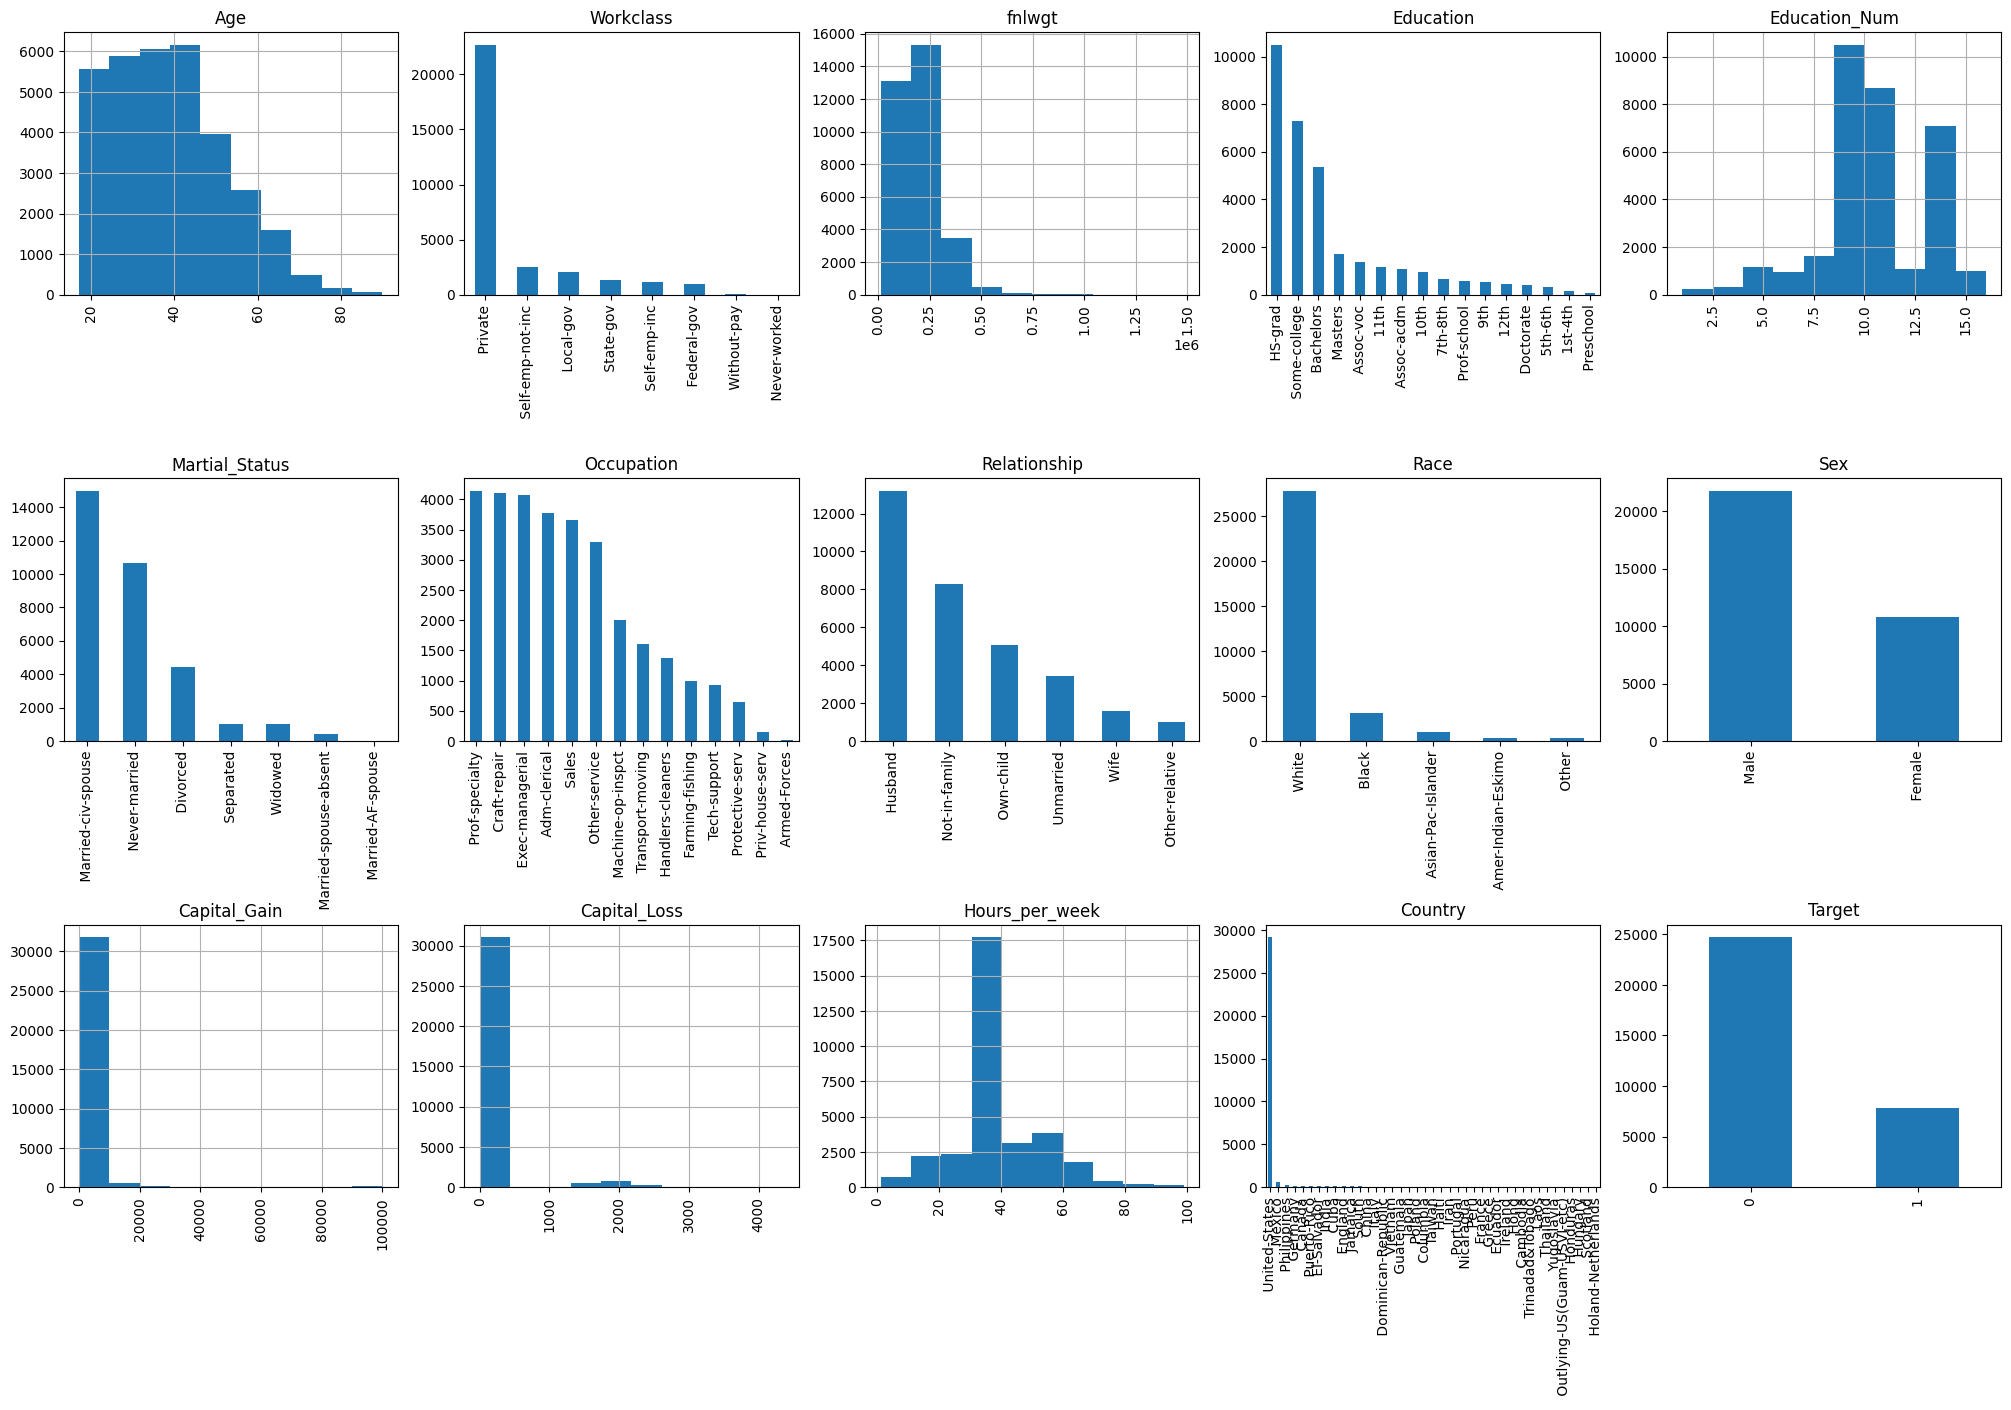

In [34]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object_:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

#### Проверка типов данных

In [35]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [36]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

Как мы видим, в тестовых данных возраст рассматривается как тип **object**. Это необходимо исправить.

In [37]:
data_test["Age"] = data_test["Age"].astype(int)

Также мы приведем все **float** признаки к **int** типу, чтобы сохранить соответствие типов между обучающими и тестовыми данными.

In [38]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

# same for the target
data_train["Target"] = data_train["Target"].astype(int)
data_test["Target"] = data_test["Target"].astype(int)

Сохраним таргет отдельно.

In [39]:
y_train = data_train.pop("Target")
y_test = data_test.pop("Target")

#### Заполним недостающие данные для непрерывных признаков их медианными значениями, для категориальных признаков - их модой.

In [40]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [41]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [42]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [43]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


Мы введем фиктивный код для некоторых категориальных признаков: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. Это можно сделать с помощью метода pandas **get_dummies**

In [44]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [45]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [46]:
data_train.shape, data_test.shape

((32561, 105), (16281, 104))

#### В тестовых данных нет Голландии. Создадим новый признак с нулевым значением.

In [47]:
data_test["Country_ Holand-Netherlands"] = 0

In [48]:
set(data_train.columns) - set(data_test.columns)

set()

In [49]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [50]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [51]:
X_train = data_train
X_test = data_test

### 3.1 Дерево решений без настройки параметров

Обучим дерево решений **(DecisionTreeClassifier)** с **максимальной глубиной**, равной 3, и оценим метрику точности на тестовых данных. Для воспроизводимости результатов используем параметр **random_state = 17**.

In [52]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

Выполнить прогнозирование с помощью обученной модели на тестовых данных.

In [53]:
tree_predictions = tree.predict(X_test[X_train.columns])

**6. Какова точность дерева решений на тестовом наборе при *максимальной глубине дерева*, равной 3, и *random_state = 17*?**

In [54]:
display(Math(f"{accuracy_score(y_test, tree_predictions):.3f}"))

<IPython.core.display.Math object>

### 3.2 Дерево решений с настройкой параметров

Обучение дерева решений **(DecisionTreeClassifier, random_state = 17).** Поиск оптимальной максимальной глубины с помощью 5-кратной перекрестной валидации **(GridSearchCV)**.

In [55]:
tree_params = {"max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17), tree_params, cv=5
)

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [56]:
print(
    f"Best params: {locally_best_tree.best_params_}\n"
    f"Best cv score: {locally_best_tree.best_score_}"
)

Best params: {'max_depth': 9}
Best cv score: 0.8565770273854106


Обучим дерево решений с максимальной глубиной 9 (оптимальное значение **max_depth**) и рассчитаем точность тестового набора. Для воспроизводимости используем параметр **random_state = 17**.

In [57]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=17)

**7. Какова точность дерева решений с максимальной глубиной 9 и *random_state = 17* на тестовом наборе?**

In [58]:
tuned_tree_predictions = tuned_tree.predict(X_test[X_train.columns])
display(Math(f"{accuracy_score(y_test, tuned_tree_predictions):.3f}"))

<IPython.core.display.Math object>

### 3.3 Случайный лес без настройки параметров

Обучим случайный лес **(RandomForestClassifier)**. Зададим число деревьев равным 100 и используем **random_state = 17**.

In [59]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

Выполним кросс-валидацию.

In [60]:
%%time
cv_scores = cross_val_score(rf, X_train, y_train, cv=3)

CPU times: user 5.08 s, sys: 20.5 ms, total: 5.1 s
Wall time: 5.1 s


In [61]:
cv_scores, cv_scores.mean()

(array([0.85194398, 0.85572139, 0.859578  ]), 0.8557477912289437)

Сделаем прогнозы для тестовых данных и оценим их точность.

In [62]:
forest_predictions = rf.predict(X_test[X_train.columns])

In [63]:
accuracy_score(y_test, forest_predictions)

0.8525274860266568

### 3.4 Случайный лес с настройкой параметров

Обучим случайный лес **(RandomForestClassifier)**. Настроим максимальную глубину и максимальное количество признаков для каждого дерева с помощью **GridSearchCV**. 

In [64]:
forest_params = {
    'max_depth': range(10, 21),
    'max_features': range(5, 105, 20)
}

locally_best_forest = GridSearchCV(
    RandomForestClassifier(n_estimators=10, random_state=17),
    forest_params,
    cv=3,
    verbose=1
)

locally_best_forest.fit(X_train, y_train)

Fitting 3 folds for each of 55 candidates, totalling 165 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=10, random_state=17),
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 20)},
             verbose=1)

In [65]:
print(
    f"Best params: {locally_best_forest.best_params_}\n"
    f"Best cv score: {locally_best_forest.best_score_}"
)

Best params: {'max_depth': 14, 'max_features': 45}
Best cv score: 0.8619822161458556


Сделаем прогнозы для тестовых данных и оценим их точность.

In [66]:
tuned_forest_predictions = locally_best_forest.predict(X_test[X_train.columns])

In [67]:
accuracy_score(y_test, tuned_forest_predictions)

0.8631533689576807